# Thermodynamic parameters of Zika Sensors

## Importing usefull packages and definition of funcions

In [1]:
import os
import os.path
from subprocess import Popen, PIPE
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


In [2]:
def reversed_complement(sequence):
    mapping = {'A': 'U', 'G': 'C', 'U': 'A', 'C': 'G'}
    sequence_upper = sequence.upper()

    complement = ''
    for c in sequence_upper:
        complement += mapping[c]

    # reverse the sequence
    return complement[::-1]

In [3]:
def split_sequence(sequence, window):
    sequences = []
    limit = len(sequence) - window + 1

    for i in range(0, limit):
        sequences.append(sequence[i:window + i])

    return sequences

In [4]:
# Calculation of the minimum free energy (MFE) secondary structure of a singular RNA sequence

def DG(sequence,result_path,wait):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()
    final=[]
    semi_final=[]

    Popen(["mfe -T 23 {}pipo".format(result_path)],shell=True, stdout=PIPE)
    time.sleep(wait)
    lenght=len(sequence)
    with open("{}pipo.mfe".format(result_path)) as res:
        for r in res:
            r = r.strip('\n')
            if not r.startswith('%'):
                r = r.split('\t')
                semi_final.append(r)

    #final.append()                

    return (float(semi_final[2][0]))

    os.remove("{}pipo.mfe".format(result_path,))
    os.remove("{}pipo.in".format(result_path))


In [5]:
# Calculation of the minimum free energy (MFE) secondary structure of a complex formed out of two equimolar RNA sequences
def DG_2(sequence1, sequence2, result_path,wait):
    
    
    file = open("{}Pipe.in".format(result_path), 'w')
    file.write("{}\n".format("2"))
    file.write("{}\n".format(sequence1))
    file.write("{}\n".format(sequence2))
    file.write("{}\n".format("1 2"))
    file.close()

    semi_final=[]
    Popen(["mfe -multi {}Pipe".format(result_path)],shell=True, stdout=PIPE)
    time.sleep(wait)
    #lenght=len(sequence)
    with open("{}Pipe.mfe".format(result_path)) as res:
        for r in res:
            r = r.strip('\n')
            if not r.startswith('%'):
                r = r.split('\t')
                semi_final.append(r)
    os.remove("{}Pipe.in".format(result_path))
    os.remove("{}Pipe.mfe".format(result_path))            
    return (float(semi_final[2][0]))

In [6]:
def parse_pairs_result(res, length):
    final = []
    for r in res:
        r = r.strip('\n')
        if not r.startswith('%'):
            r = r.split('\t')
            if len(r) == 3:
                if r[1] == str(length+1):
                    final.append(float(r[2]))

    return final

In [7]:

def norm_single_streadness(sequence, result_path, wait=1):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    sin=parsed_res
    
    single=(np.sum(sin)/len(sin))


    return single

In [8]:
def complex_defect(sequence, secondary, result_path):
    file = open('{}toeh.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.write("{}".format(secondary))
    file.close()

    defect_toeh = 0
    count = 0
    with Popen(["complexdefect", "{}toeh".format(result_path)], stdout=PIPE) as proc:
        res = (proc.stdout.read()).decode("utf-8").split('\n')
        for l in res:
            count += 1
            if count == 16:
                defect_toeh = float(l)

    os.remove("{}toeh.in".format(result_path))
    return defect_toeh

In [9]:

def all_single_streadness(sequence, result_path, wait=1):
    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    sin=parsed_res
    


    return sin

## Loadding results

In [10]:
#Read results
Serie_A=pd.read_csv("Serie_A.csv")
Serie_A['Serie'] = 'Serie A'


In [11]:
#Read results
Serie_B=pd.read_csv("Serie_B.csv")
#a["Sensor"]=ind
Serie_B['Serie'] = 'Serie B'

In [14]:
#Concatenate the two dataframes
frames=[Serie_A,Serie_B]
result_2 = pd.concat(frames)
result_2;

In [17]:
#for i in range(len(result_2.iloc[:,2])):
   # print(len(result_2.iloc[i,2]))

IndentationError: unexpected indent (<ipython-input-17-c37055dd03d6>, line 2)


## Comparison of Series A and Series B 

#### Avegage ON/Off rate distributions of Series A and  B are similar but higher values are observed in Series B. Also, both series have several sensors that show poor ON-OFF rate, which indicates a low probability of succes in the design of effective sensors. Also in ZIka's paper, they showed that Series B popultion have lower background than Series A.

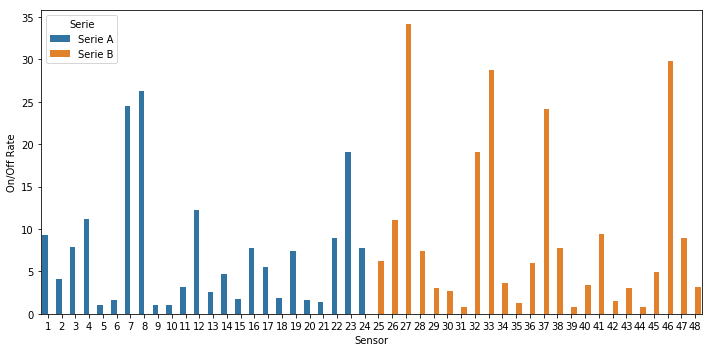

In [18]:

f, ax = plt.subplots(figsize=(10,5))

sns.barplot(x=result_2.Sensor,y=result_2.iloc[:,1],hue=result_2.Serie)
plt.tight_layout()


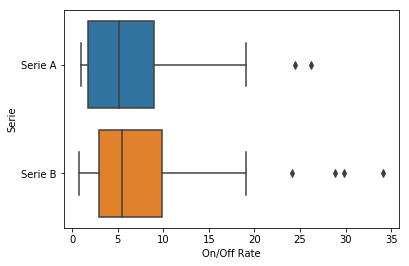

In [19]:
sns.boxplot(x=result_2.iloc[:,1],y=result_2.Serie)

## Calculating thermodynamic parameters of Series B sensors 


### Parameter definitions:
#### Dg_Switch: is the Free Energy of the longer switch RNA composing the first 97 nt after the GGG leadder sequence.
#### Dg_Trigger: is the Free Energy of the entire trigger RNA composing 36 nt that bind to the toehold domain and the displacement sequence
#### Single_Streadness_Trigger: Is the normalized single streadness of the trigger RNA
#### Dg_RBS_linker: Represents the minimum free energy (MFE) secondary structure of the sequence between the RBS until the start of the "linker" nucleotide position 47 until 9.
#### Trigger_Deffect: Represents the average number of paired nucleotides at equilibrium in the trigger RNA. This is a quantification of a "normalized defect", because the trigger optimal design is a perfectlly single stranded sequence.
#### Sensor_Defect: representing the average number of incorrectly paired nucleotides at equilibrium evaluated over the ensemble of the complex 
#### sensor designed optimal structure: ".........................(((((((((((...(((((............)))))...)))))))))))......................"


In [20]:
Dg_Switch=[]
for i in range(len(Serie_B.iloc[:,2])):
    Dg_Switch.append(DG(Serie_B.iloc[i,2],"Temp/",1))
P1=pd.Series(Dg_Switch)
Serie_B["DeltaG_Switch"]=P1.values

In [21]:
Dg_trigger=[]
for i in range(len(Serie_B.iloc[:,3])):
    Dg_trigger.append(DG(Serie_B.iloc[i,3],"Temp/",1))
P2=pd.Series(Dg_trigger)
Serie_B["DeltaG_Trigger"]=P2.values

In [22]:
SS_Trigger=[]
for i in range(len(Serie_B.iloc[:,3])):
    SS_Trigger.append(norm_single_streadness(Serie_B.iloc[i,3],"Temp/",2))
P3=pd.Series(SS_Trigger)
Serie_B["Single_Streadness_Trigger"]=P3.values

In [23]:
Dg_RBS_linker=[]
for i in range(len(Serie_B.iloc[:,3])):
    RBS_linker=Serie_B.iloc[i,2][48:96]
    Dg_RBS_linker.append(DG(RBS_linker,"",2))
P4=pd.Series(Dg_RBS_linker)
Serie_B["Dg_RBS_linker"]=P4.values

In [24]:
Serie_B

,Sensor,On/Off Rate,Sensor Sequence,Trigger Sequence,Amplification sequence,Serie,DeltaG_Switch,DeltaG_Trigger,Single_Streadness_Trigger,Dg_RBS_linker
0,25,6.186667,UCUUCAGCCUCCAUGUGUCAUUCUUCUCACUCUCAAGGACUUUAGA...,UUGAGAGUGAGAAGAAUGACACAUGGAGGCUGAAGA,GGGCAGUGAUCUAGGCUACUGGAUUGAGAGUGAGAAGAAUGACACA...,Serie B,-35.551,-3.175,0.820792,-8.469
1,26,11.093333,AAAUUCCCCUUGUUUCUUUUCUCUUUUUCCCAUCAUGGACUUUAGA...,AUGAUGGGAAAAAGAGAAAAGAAACAAGGGGAAUUU,GGGUGCCAGAGUUGUGUGUACAACAUGAUGGGAAAAAGAGAAAAGA...,Serie B,-31.870,-0.396,0.890751,-7.898
2,27,34.133333,UUUCGCUCUAUUCUCAUCAGUUUCAUGUCCUGUGUCGGACUUUAGA...,GACACAGGACAUGAAACUGAUGAGAAUAGAGCGAAA,GGGCCAGCACAGUGGGAUGAUCGUUAAUGACACAGGACAUGAAACU...,Serie B,-36.519,-4.615,0.773636,-9.988
3,28,7.360000,GCUCCCCUUCUACUGAUCUCCACAUGAUGUUUUCCAGGACUUUAGA...,UGGAAAACAUCAUGUGGAGAUCAGUAGAAGGGGAGC,GGGCGGGAUCUCCUCUGUUUCAAGAAUGGAAAACAUCAUGUGGAGA...,Serie B,-30.502,-4.200,0.758035,-14.356
4,29,2.986667,AACUUCUUUAUUAUUUCCAUAGCCUCUUUUUUCCCCGGACUUUAGA...,GGGGAAAAAAGAGGCUAUGGAAAUAAUAAAGAAGUU,GGGCCAUCACUGGGUCUCAUCAAUAGAUGGGGUUCAGUGGGGAAAA...,Serie B,-30.709,-2.603,0.833765,-7.706
5,30,2.666667,AGGGUGGCUUCGGCUCUUGGUGAAUUGGGCGUUAUCGGACUUUAGA...,GAUAACGCCCAAUUCACCAAGAGCCGAAGCCACCCU,GGGAAUGCUGUCAGUUCAUGGCUCCCAGCACAGUGGGAUGAUCGUU...,Serie B,-40.821,-3.234,0.810051,-11.621
6,31,0.746667,CUUCCACUGCAGUCUUCCACUCUUUUUCCUCUUCAAGGACUUUAGA...,UUGAAGAGGAAAAAGAGUGGAAGACUGCAGUGGAAG,GGGAGAAGGAUGGUCUCUUCCUGGUUGUGGAAAGAGCUAGGCAAAC...,Serie B,-35.203,-4.160,0.781046,-9.128
7,32,19.093333,CUGGGAUCAAGUACAUGUAGUGCGCCACGAGCAAAAGGACUUUAGA...,UUUUGCUCGUGGCGCACUACAUGUACUUGAUCCCAG,GGGCUGACCCUAAUAGUGGCCAUCAUUUUGCUCGUGGCGCACUACA...,Serie B,-33.682,-6.100,0.673751,-13.048
8,33,28.800000,ACUAUUAGGGUCAGGGGUGUUAAUUGUGAGUAGCAAGGACUUUAGA...,UUGCUACUCACAAUUAACACCCCUGACCCUAAUAGU,GGGUUUGGUAUGGGCAAAGGGAUGCCAUUCUACGCAUGGGACUUUG...,Serie B,-36.733,-1.457,0.819184,-12.105
9,34,3.626667,CAUCGCCAUUAAGGAGUAGUUGUUGUAUGAGGUGGUGGACUUUAGA...,ACCACCUCAUACAACAACUACUCCUUAAUGGCGAUG,GGGCCAUCUAUGCUGCCUUGACAACUUUCAUUACCCCAGCCGUCCA...,Serie B,-38.465,-1.859,0.829996,-11.527


## Calculating linear regressions and coefficients

In [ ]:
#until this point, we've calculated parameters of the sensors and triggers. Lets see if any correlates with the ON-OFF responce

In [201]:
range(6,len(Serie_B.columns)-1)

range(6, 9)

,name,R-squared,R-squared-adj,Linear model Coef,p-value
0,DeltaG_Switch,0.048547,0.005299,0.617839,0.300867
1,DeltaG_Trigger,0.011631,-0.033295,0.394945,0.615951
2,Single_Streadness_Trigger,0.016843,-0.027846,-18.483702,0.545562
3,Dg_RBS_linker,0.002272,-0.043080,-0.186651,0.824973


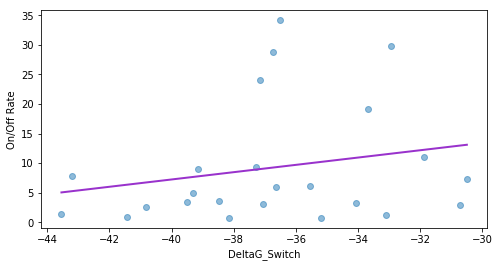

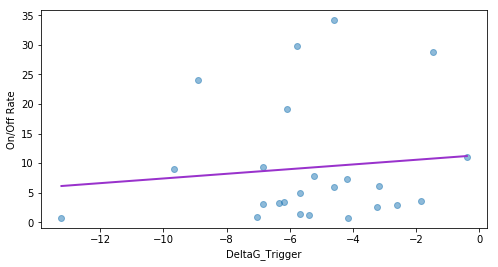

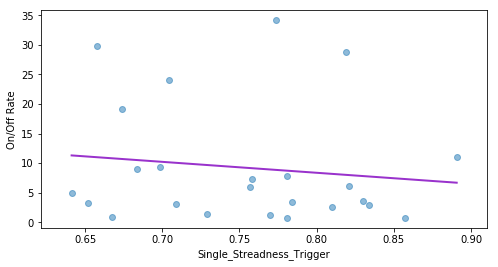

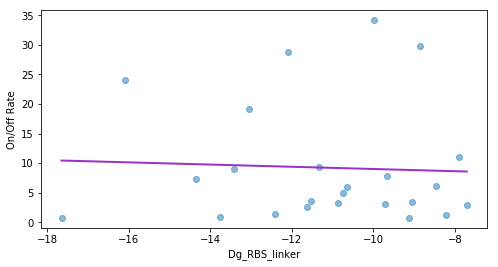

In [207]:
list_of_lists = []
for i in range(6,len(Serie_B.columns)):
    y=Serie_B["On/Off Rate"]
    x=Serie_B[Serie_B.columns[i]]
    y.shape
    x.shape
    name=x.name

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(x, y, alpha=0.5)
    plt.xlabel(x.name)
    plt.ylabel(y.name)

    x_pred = np.linspace(x.min(), x.max(), 50)
    x=sm.add_constant(x)

    #model y=mx+c
    regression1=sm.OLS(y,x).fit() 

    x_pred2 = sm.add_constant(x_pred)
    y_pred = regression1.predict(x_pred2)
    ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)
    
    list_of_lists.append([name,regression1.rsquared,regression1.rsquared_adj,regression1.params[1],regression1.pvalues[1] ])
out=pd.DataFrame(list_of_lists, columns=['name', 'R-squared', 'R-squared-adj',"Linear model Coef","p-value"])
out



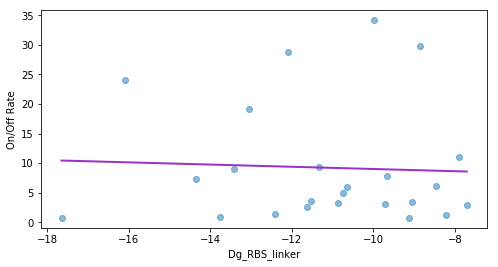

In [208]:
import statsmodels.api as sm 
#x = sm.add_constant(x) # constant intercept term

y=Serie_B["On/Off Rate"]
x=Serie_B["Dg_RBS_linker"]
y.shape
x.shape
name=x.name
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x, y, alpha=0.5)
plt.xlabel(x.name)
plt.ylabel(y.name)

x_pred = np.linspace(x.min(), x.max(), 50)
x=sm.add_constant(x)

#model y=mx+c
regression1=sm.OLS(y,x).fit() 

x_pred2 = sm.add_constant(x_pred)
y_pred = regression1.predict(x_pred2)
ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)



In [185]:
#print(regression1.summary())

In [186]:
#regression1.rsquared
#regression1.rsquared_adj
#regression1.pvalues[1]


In [183]:
list_of_lists = []
list_of_lists.append([name,regression1.rsquared,regression1.rsquared_adj,regression1.params[1],regression1.pvalues[1] ])
out=pd.DataFrame(list_of_lists, columns=['name', 'R-squared', 'R-squared-adj',"Coef","p-value"])
out

,name,R-squared,R-squared-adj,Coef,p-value
0,Dg_RBS_linker,0.002272,-0.04308,-0.186651,0.824973


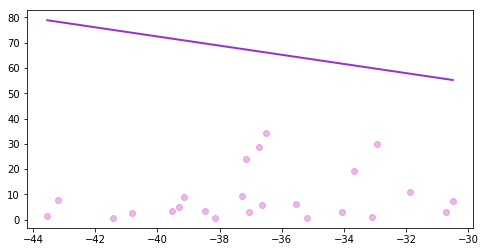

In [67]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x1, y, alpha=0.5, color='orchid')
x_pred = np.linspace(x.iloc[:,1].min(), x.iloc[:,1].max(), 50)
x_pred2 = sm.add_constant(x_pred)
y_pred = regression1.predict(x_pred2[:,1])
ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)

In [20]:
dTrigger=[]
for i in range(len(Serie_B.iloc[:,8])):
    dTrigger.append(1-Serie_B.iloc[i,8])
P5=pd.Series(dTrigger)
Serie_B["Trigger_Deffect"]=P5.values

In [59]:
sensor_des_structure=".........................(((((((((((...(((((............)))))...)))))))))))......................"

Sensor_Defect=[]
for i in range(len(Serie_B.iloc[:,2])): 
    Sensor_Defect.append(complex_defect(Serie_B.iloc[i,2],sensor_des_structure,"Temp/"))
P6=pd.Series(Sensor_Defect)
Serie_B["Sensor_Defect"]=P6.values

In [60]:
Serie_B

,Sensor,On/Off Rate,Sensor Sequence,Trigger Sequence,Amplification sequence,Serie,DeltaG_Switch,DeltaG_Trigger,Single_Streadness_Trigger,Trigger_Deffect,Dg_RBS_linker,Sensor_Defect
0,25,6.186667,UCUUCAGCCUCCAUGUGUCAUUCUUCUCACUCUCAAGGACUUUAGA...,UUGAGAGUGAGAAGAAUGACACAUGGAGGCUGAAGA,GGGCAGUGAUCUAGGCUACUGGAUUGAGAGUGAGAAGAAUGACACA...,Serie B,-35.551,-3.175,0.820792,0.179208,-8.469,0.1956
1,26,11.093333,AAAUUCCCCUUGUUUCUUUUCUCUUUUUCCCAUCAUGGACUUUAGA...,AUGAUGGGAAAAAGAGAAAAGAAACAAGGGGAAUUU,GGGUGCCAGAGUUGUGUGUACAACAUGAUGGGAAAAAGAGAAAAGA...,Serie B,-31.870,-0.396,0.890751,0.109249,-7.898,0.3662
2,27,34.133333,UUUCGCUCUAUUCUCAUCAGUUUCAUGUCCUGUGUCGGACUUUAGA...,GACACAGGACAUGAAACUGAUGAGAAUAGAGCGAAA,GGGCCAGCACAGUGGGAUGAUCGUUAAUGACACAGGACAUGAAACU...,Serie B,-36.519,-4.615,0.773636,0.226364,-9.988,0.2898
3,28,7.360000,GCUCCCCUUCUACUGAUCUCCACAUGAUGUUUUCCAGGACUUUAGA...,UGGAAAACAUCAUGUGGAGAUCAGUAGAAGGGGAGC,GGGCGGGAUCUCCUCUGUUUCAAGAAUGGAAAACAUCAUGUGGAGA...,Serie B,-30.502,-4.200,0.758035,0.241965,-14.356,0.1605
4,29,2.986667,AACUUCUUUAUUAUUUCCAUAGCCUCUUUUUUCCCCGGACUUUAGA...,GGGGAAAAAAGAGGCUAUGGAAAUAAUAAAGAAGUU,GGGCCAUCACUGGGUCUCAUCAAUAGAUGGGGUUCAGUGGGGAAAA...,Serie B,-30.709,-2.603,0.833765,0.166235,-7.706,0.1528
5,30,2.666667,AGGGUGGCUUCGGCUCUUGGUGAAUUGGGCGUUAUCGGACUUUAGA...,GAUAACGCCCAAUUCACCAAGAGCCGAAGCCACCCU,GGGAAUGCUGUCAGUUCAUGGCUCCCAGCACAGUGGGAUGAUCGUU...,Serie B,-40.821,-3.234,0.810051,0.189949,-11.621,0.2493
6,31,0.746667,CUUCCACUGCAGUCUUCCACUCUUUUUCCUCUUCAAGGACUUUAGA...,UUGAAGAGGAAAAAGAGUGGAAGACUGCAGUGGAAG,GGGAGAAGGAUGGUCUCUUCCUGGUUGUGGAAAGAGCUAGGCAAAC...,Serie B,-35.203,-4.160,0.781046,0.218954,-9.128,0.2569
7,32,19.093333,CUGGGAUCAAGUACAUGUAGUGCGCCACGAGCAAAAGGACUUUAGA...,UUUUGCUCGUGGCGCACUACAUGUACUUGAUCCCAG,GGGCUGACCCUAAUAGUGGCCAUCAUUUUGCUCGUGGCGCACUACA...,Serie B,-33.682,-6.100,0.673751,0.326249,-13.048,0.1892
8,33,28.800000,ACUAUUAGGGUCAGGGGUGUUAAUUGUGAGUAGCAAGGACUUUAGA...,UUGCUACUCACAAUUAACACCCCUGACCCUAAUAGU,GGGUUUGGUAUGGGCAAAGGGAUGCCAUUCUACGCAUGGGACUUUG...,Serie B,-36.733,-1.457,0.819184,0.180816,-12.105,0.2088
9,34,3.626667,CAUCGCCAUUAAGGAGUAGUUGUUGUAUGAGGUGGUGGACUUUAGA...,ACCACCUCAUACAACAACUACUCCUUAAUGGCGAUG,GGGCCAUCUAUGCUGCCUUGACAACUUUCAUUACCCCAGCCGUCCA...,Serie B,-38.465,-1.859,0.829996,0.170004,-11.527,0.2389


In [87]:
from sklearn import linear_model
import statsmodels.api as sm

/home/anibal/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [111]:
fx=-1.08715198+33.10708952*Serie_B["Trigger_Deffect"]-3.25*Serie_B["Sensor_Defect"]+1.2965726*Serie_B["DeltaG_Trigger"]-0.88692061*Serie_B["Dg_RBS_linker"]

In [112]:
Y

,On/Off Rate
0,6.186667
1,11.093333
2,34.133333
3,7.360000
4,2.986667
5,2.666667
6,0.746667
7,19.093333
8,28.800000
9,3.626667


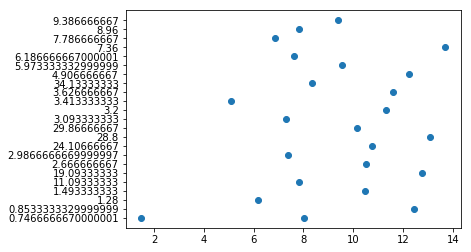

In [115]:
plt.scatter(fx,Y)

In [130]:

X = Serie_B[["Sensor_Defect","DeltaG_Trigger"]] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = Serie_B[["On/Off Rate"]] 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 [ 15.8958504]
Coefficients: 
 [[-18.00546201   0.44286989]]
                            OLS Regression Results                            
Dep. Variable:            On/Off Rate   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.2508
Date:                Mon, 31 Dec 2018   Prob (F-statistic):              0.780
Time:                        02:34:18   Log-Likelihood:                -88.800
No. Observations:                  24   AIC:                             183.6
Df Residuals:                      21   BIC:                             187.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

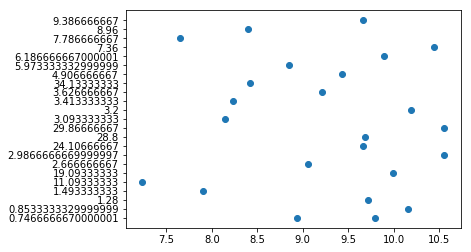

In [128]:
plt.scatter(12.94282798-15.60454284*Serie_B["Sensor_Defect"],Y)

In [ ]:
Dg_Complex=[]
for i in range(len(a.iloc[:,3])):
    Dg_Complex.append(DG_2(a.iloc[i,2],a.iloc[i,3],"",2))
P4=pd.Series(Dg_Complex)
Serie_B["DeltaG_Complex"]=P4.values

0.00891447110561


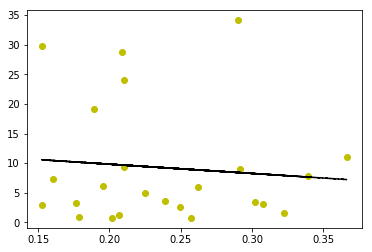

In [82]:
x=Serie_B.loc[:,"Sensor_Defect"]
y=Serie_B.loc[:,"On/Off Rate"]
print(rsquared(x,y))
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)
#plt.scatter(x ,y)

In [80]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [44]:
c=0
for i in ".........................(((((((((((...(((((............)))))...)))))))))))......................":
    print (i,c)
    c=c+1

. 0
. 1
. 2
. 3
. 4
. 5
. 6
. 7
. 8
. 9
. 10
. 11
. 12
. 13
. 14
. 15
. 16
. 17
. 18
. 19
. 20
. 21
. 22
. 23
. 24
( 25
( 26
( 27
( 28
( 29
( 30
( 31
( 32
( 33
( 34
( 35
. 36
. 37
. 38
( 39
( 40
( 41
( 42
( 43
. 44
. 45
. 46
. 47
. 48
. 49
. 50
. 51
. 52
. 53
. 54
. 55
) 56
) 57
) 58
) 59
) 60
. 61
. 62
. 63
) 64
) 65
) 66
) 67
) 68
) 69
) 70
) 71
) 72
) 73
) 74
. 75
. 76
. 77
. 78
. 79
. 80
. 81
. 82
. 83
. 84
. 85
. 86
. 87
. 88
. 89
. 90
. 91
. 92
. 93
. 94
. 95
. 96


In [ ]:
a.iloc[11,4][101:(101+len(a.iloc[11,3]))]

In [ ]:
a.iloc[:,2]

In [ ]:
#FInding where starts the sequence of the trigger in the amplifyed sequence
from skbio import Sequence
s = Sequence(a.iloc[11,4])
s.index(a.iloc[11,3])



Text(0,0.5,'On/Off ratio')

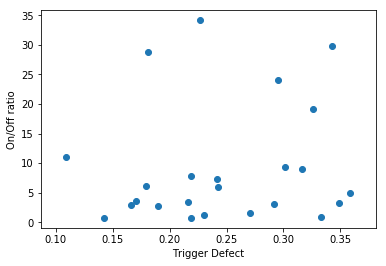

In [35]:
plt.scatter(Serie_B.iloc[:,9],Serie_B.iloc[:,1])
plt.xlabel("Trigger Defect")
plt.ylabel("On/Off ratio")

In [36]:
Serie_B.loc[:,"Trigger_Deffect"]

0     0.179208
1     0.109249
2     0.226364
3     0.241965
4     0.166235
5     0.189949
6     0.218954
7     0.326249
8     0.180816
9     0.170004
10    0.230325
11    0.242881
12    0.295375
13    0.218892
14    0.142509
15    0.215953
16    0.301682
17    0.270858
18    0.291347
19    0.332862
20    0.358732
21    0.342569
22    0.316113
23    0.348353
Name: Trigger_Deffect, dtype: float64

In [ ]:
LacZ=str("AUGACCAUGAUUACGGAUUCACUGGCCGUCGUUUUACAACGUCGUGACUGGGAAAACCCUGGCGUUACCCAACUUAAUCGCCUUGCAGCACAUCCCCCUUUCGCCAGCUGGCGUAAUAGCGAAGAGGCCCGCACCGAUCGCCCUUCCCAACAGUUGCGCAGCCUGAAUGGCGAAUGGCGCUUUGCCUGGUUUCCGGCACCAGAAGCGGUGCCGGAAAGCUGGCUGGAGUGCGAUCUUCCUGAGGCCGAUACUGUCGUCGUCCCCUCAAACUGGCAGAUGCACGGUUACGAUGCGCCCAUCUACACCAACGUGACCUAUCCCAUUACGGUCAAUCCGCCGUUUGUUCCCACGGAGAAUCCGACGGGUUGUUACUCGCUCACAUUUAAUGUUGAUGAAAGCUGGCUACAGGAAGGCCAGACGCGAAUUAUUUUUGAUGGCGUUAACUCGGCGUUUCAUCUGUGGUGCAACGGGCGCUGGGUCGGUUACGGCCAGGACAGUCGUUUGCCGUCUGAAUUUGACCUGAGCGCAUUUUUACGCGCCGGAGAAAACCGCCUCGCGGUGAUGGUGCUGCGCUGGAGUGACGGCAGUUAUCUGGAAGAUCAGGAUAUGUGGCGGAUGAGCGGCAUUUUCCGUGACGUCUCGUUGCUGCAUAAACCGACUACACAAAUCAGCGAUUUCCAUGUUGCCACUCGCUUUAAUGAUGAUUUCAGCCGCGCUGUACUGGAGGCUGAAGUUCAGAUGUGCGGCGAGUUGCGUGACUACCUACGGGUAACAGUUUCUUUAUGGCAGGGUGAAACGCAGGUCGCCAGCGGCACCGCGCCUUUCGGCGGUGAAAUUAUCGAUGAGCGUGGUGGUUAUGCCGAUCGCGUCACACUACGUCUGAACGUCGAAAACCCGAAACUGUGGAGCGCCGAAAUCCCGAAUCUCUAUCGUGCGGUGGUUGAACUGCACACCGCCGACGGCACGCUGAUUGAAGCAGAAGCCUGCGAUGUCGGUUUCCGCGAGGUGCGGAUUGAAAAUGGUCUGCUGCUGCUGAACGGCAAGCCGUUGCUGAUUCGAGGCGUUAACCGUCACGAGCAUCAUCCUCUGCAUGGUCAGGUCAUGGAUGAGCAGACGAUGGUGCAGGAUAUCCUGCUGAUGAAGCAGAACAACUUUAACGCCGUGCGCUGUUCGCAUUAUCCGAACCAUCCGCUGUGGUACACGCUGUGCGACCGCUACGGCCUGUAUGUGGUGGAUGAAGCCAAUAUUGAAACCCACGGCAUGGUGCCAAUGAAUCGUCUGACCGAUGAUCCGCGCUGGCUACCGGCGAUGAGCGAACGCGUAACGCGAAUGGUGCAGCGCGAUCGUAAUCACCCGAGUGUGAUCAUCUGGUCGCUGGGGAAUGAAUCAGGCCACGGCGCUAAUCACGACGCGCUGUAUCGCUGGAUCAAAUCUGUCGAUCCUUCCCGCCCGGUGCAGUAUGAAGGCGGCGGAGCCGACACCACGGCCACCGAUAUUAUUUGCCCGAUGUACGCGCGCGUGGAUGAAGACCAGCCCUUCCCGGCUGUGCCGAAAUGGUCCAUCAAAAAAUGGCUUUCGCUACCUGGAGAGACGCGCCCGCUGAUCCUUUGCGAAUACGCCCACGCGAUGGGUAACAGUCUUGGCGGUUUCGCUAAAUACUGGCAGGCGUUUCGUCAGUAUCCCCGUUUACAGGGCGGCUUCGUCUGGGACUGGGUGGAUCAGUCGCUGAUUAAAUAUGAUGAAAACGGCAACCCGUGGUCGGCUUACGGCGGUGAUUUUGGCGAUACGCCGAACGAUCGCCAGUUCUGUAUGAACGGUCUGGUCUUUGCCGACCGCACGCCGCAUCCAGCGCUGACGGAAGCAAAACACCAGCAGCAGUUUUUCCAGUUCCGUUUAUCCGGGCAAACCAUCGAAGUGACCAGCGAAUACCUGUUCCGUCAUAGCGAUAACGAGCUCCUGCACUGGAUGGUGGCGCUGGAUGGUAAGCCGCUGGCAAGCGGUGAAGUGCCUCUGGAUGUCGCUCCACAAGGUAAACAGUUGAUUGAACUGCCUGAACUACCGCAGCCGGAGAGCGCCGGGCAACUCUGGCUCACAGUACGCGUAGUGCAACCGAACGCGACCGCAUGGUCAGAAGCCGGGCACAUCAGCGCCUGGCAGCAGUGGCGUCUGGCGGAAAACCUCAGUGUGACGCUCCCCGCCGCGUCCCACGCCAUCCCGCAUCUGACCACCAGCGAAAUGGAUUUUUGCAUCGAGCUGGGUAAUAAGCGUUGGCAAUUUAACCGCCAGUCAGGCUUUCUUUCACAGAUGUGGAUUGGCGAUAAAAAACAACUGCUGACGCCGCUGCGCGAUCAGUUCACCCGUGCACCGCUGGAUAACGACAUUGGCGUAAGUGAAGCGACCCGCAUUGACCCUAACGCCUGGGUCGAACGCUGGAAGGCGGCGGGCCAUUACCAGGCCGAAGCAGCGUUGUUGCAGUGCACGGCAGAUACACUUGCUGAUGCGGUGCUGAUUACGACCGCUCACGCGUGGCAGCAUCAGGGGAAAACCUUAUUUAUCAGCCGGAAAACCUACCGGAUUGAUGGUAGUGGUCAAAUGGCGAUUACCGUUGAUGUUGAAGUGGCGAGCGAUACACCGCAUCCGGCGCGGAUUGGCCUGAACUGCCAGCUGGCGCAGGUAGCAGAGCGGGUAAACUGGCUCGGAUUAGGGCCGCAAGAAAACUAUCCCGACCGCCUUACUGCCGCCUGUUUUGACCGCUGGGAUCUGCCAUUGUCAGACAUGUAUACCCCGUACGUCUUCCCGAGCGAAAACGGUCUGCGCUGCGGGACGCGCGAAUUGAAUUAUGGCCCACACCAGUGGCGCGGCGACUUCCAGUUCAACAUCAGCCGCUACAGUCAACAGCAACUGAUGGAAACCAGCCAUCGCCAUCUGCUGCACGCGGAAGAAGGCACAUGGCUGAAUAUCGACGGUUUCCAUAUGGGGAUUGGUGGCGACGACUCCUGGAGCCCGUCAGUAUCGGCGGAAUUCCAGCUGAGCGCCGGUCGCUACCAUUACCAGUUGGUCUGGUGUCAAAAAUAAAGGU")

In [ ]:
complete_Sensor=[]
for i in range(len((a.iloc[:,4]))):
    complete_Sensor.append(a.iloc[i,2]+ str(LacZ))
p20=complete_Sensor
a["Complete_Sensor"]=p20

In [ ]:
a.iloc[:,9]

In [ ]:
def ss_in_context(sequence,sub_sequence,result_path, wait=1):
    s = Sequence(sequence)
    initial=s.index(sub_sequence)

    file = open('{}pipo.in'.format(result_path), 'w')
    file.write("{}\n".format(sequence))
    file.close()

    Popen(["pairs", "{}pipo".format(result_path)], stdout=PIPE)
    time.sleep(wait)
    with open("{}pipo.ppairs".format(result_path)) as res:
        parsed_res = parse_pairs_result(res, len(sequence))

    os.remove("{}pipo.ppairs".format(result_path,))
    os.remove("{}pipo.in".format(result_path))
    
    
    sin=parsed_res[initial:initial+len(sub_sequence)]
    norm=(np.sum(sin)/len(sin))


    return norm

In [ ]:
s = Sequence(a.iloc[11,4])
s.index(a.iloc[11,3])
len(a.iloc[11,4])
b=ss_in_context(a.iloc[11,4],a.iloc[11,3],"",5)
b

In [ ]:
SS_Trigger_in_context=[]
for i in range(len(a.iloc[:,3])):
    print("Calculating" +str(i))
    sin=ss_in_context(a.iloc[i,4],a.iloc[i,3],"",5)
    SS_Trigger_in_context.append(sin)

SS_Trigger_in_context

In [ ]:
p9=pd.Series(SS_Trigger_in_context)
a["SS_Th_in_context"]=p9
a


In [ ]:
p7=pd.Series(SS_Trigger_in_context)
a["SS_Trigger_in_context"]=p7

In [ ]:
a.iloc[:,2]

In [ ]:
t=Sequence(a.iloc[i,2][0:25])
t

In [ ]:
a.iloc[:,9]

In [ ]:
a.iloc[8,9]

In [ ]:
s = Sequence(a.iloc[i,9])
initial=s.index(a.iloc[i,2][0:25])
with open("{}pipo.ppairs".format("")) as res:
    parsed_res = parse_pairs_result(res, len(a.iloc[i,9]))

    os.remove("{}pipo.ppairs".format("",))
    os.remove("{}pipo.in".format(""))
    
    
    sin=parsed_res[initial:initial+len(a.iloc[i,2][0:25])]
    norm=(np.sum(sin)/len(sin))
norm

In [ ]:
SS_Toehold_in_context=[]
for i in range(len(a.iloc[:,3])):
    print("Calculating" +str(i))
    SS_Toehold_in_context.append(ss_pin_context(a.iloc[i,9],a.iloc[i,2][0:25],"",6000))

In [ ]:
SS_Toehold_in_context

In [ ]:
types=[]
for i in range(len(a.iloc[:,3])):
    if (a.iloc[i,2][25])=="C"or (a.iloc[i,2][25])=="G":
        types.append("S")
    else:
        types.append("W")

    print(a.iloc[i,2][25],types[i])  
    

In [ ]:
types_2=[]
for i in range(len(a.iloc[:,3])):
    if (a.iloc[i,2][26])=="C" or (a.iloc[i,2][26])=="G":
        types_2.append("S")
    else:
        types_2.append("W")
    print(a.iloc[i,2][26],types_2[i]) 

In [ ]:
two=[]
for i in range(len(types_2)):
    two.append(types[i] + types_2[i])

In [ ]:
for i in range(len(types_2)):
    print(a.iloc[i,1],two[i])

In [ ]:
p8=pd.Series(types)
a["First_invading"]=p8

In [ ]:
#correlation first analisis
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

plt.figure(figsize=(5,20))

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    pos = (.1, .9) if kws['label'] == 'W' else (.1,.8)
    ax.annotate("r = {:.2f}".format(kws['label'],r),
                xy=pos, xycoords=ax.transAxes)
    



  
    
g = sns.pairplot(a, 
                 y_vars=["On/Off Rate"],
                 x_vars=["SS_Th_in_context","DeltaG_Switch","SS_Trigger_in_context","DeltaG_Complex","DeltaG_Trigger","Dg_RBS_linker","Single_Streadness_Trigger","diff_DG"],
                 hue="First_invading")
                
#g.map(corrfunc)
#plt.show()  
#g.map_diag(sns.distplot, kde=False)
#g.map_lower(sns.kdeplot, cmap="Blues_d")


plt.tight_layout()
plt.savefig("para_B.pdf",dpi=500)



In [ ]:
p9=pd.Series(two)
a["First2_invading"]=p9

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

plt.figure(figsize=(20,20))
c=0
Dg_INv_f=[]
inviding_f=[]
for j in range(len(a.iloc[:,3])):
    Dg_INv=[]
    inviding=[]
    c=j+1
    ax=plt.subplot(6,4,c)
    
    for i in range(13):
        print(a.iloc[j,3][(13-i):])
        Dg_INv.append(DG_2(a.iloc[j,2],a.iloc[j,3][(13-i):],"",2))
        inviding.append(i)
    Dg_INv_f.append(Dg_INv)
    inviding_f.append(j)
    plt.xlabel("Number of invading nucleotides")
    plt.ylabel("Free Energy of the complex")

    plt.plot(inviding,Dg_INv,label="Sensor %s B + Trigger"  % str(a.Sensor[j]))
    plt.legend(loc=0)
#plt.show() 

plt.tight_layout()
plt.savefig("Serie_B.pdf",dpi=500)

In [ ]:
diff_DG=[]
for i in range(len(a.iloc[:,3])):
    diff_DG.append(Dg_INv_f[i][0]-Dg_INv_f[i][-1])
P4=pd.Series(diff_DG)
a["diff_DG"]=P4.values 

In [ ]:
range(24)

In [ ]:
Dg_RBS_linker=[]
for i in range(len(a.iloc[:,3])):
    RBS_linker=a.iloc[i,2][48:96]
    Dg_RBS_linker.append(DG(RBS_linker,"",2))
P11=pd.Series(Dg_RBS_linker)

In [ ]:
a["Dg_RBS_linker"]=P11.values

In [ ]:
a

In [ ]:
plt.gca?

In [ ]:
a
